<a href="https://colab.research.google.com/github/yeb2Binfang/DS_GY_3001_CV/blob/main/HW/HW2/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2: Canny edge detector

**Due date:** October 15th 2019

The goal of the assignment is to implement a Canny edge detector. You should return the completed notebook, including answers and illustrations. 

If you are using [anaconda](https://www.anaconda.com/distribution/) you will have necessary libraries, if not, you may need to install them.

**Load and visualize image**

--2021-03-07 00:18:51--  https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105764 (103K) [image/jpeg]
Saving to: ‘lena.jpg’

lena.jpg            100%[===================>] 103.29K  --.-KB/s    in 0.02s   

2021-03-07 00:18:51 (4.09 MB/s) - ‘lena.jpg’ saved [105764/105764]



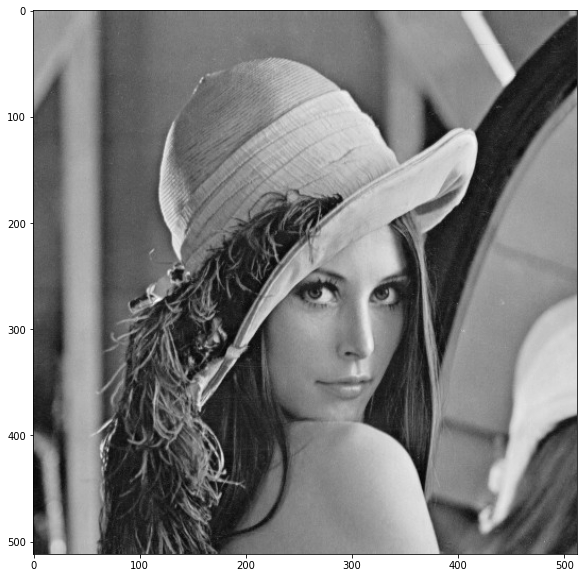

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.ndimage as ndimage #image processing library

# by default, the grayscale images are displayed with the jet colormap: use grayscale instead
plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
# get image
!wget https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg -O lena.jpg
name = './lena.jpg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

**Detailed instructions:**

https://www.cnblogs.com/king-lps/p/8007134.html

a- Compute a binary image corresponding to thresholding the norm of the gradient. You may use the function `ndimage.gaussian_filter` to compute the derivative of gaussian filter (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)). Discuss the parameters (there are two) and their influence on the results.

steps:

* We got the grey image above. Then we need to convolve with gaussian_filter to smooth the image. The noise will cause false edge detection result. Therefore, we need to smooth the image.  Gaussian_filter is a better way to remove the noise. The Gaussian filter is a 2d matrix. The equation of Gaussian filter kerel of size (2k+1) x (2k+1) is $H_{ij}=\frac{1}{2πσ^2}e^{\frac{(i-(k+1))^2+(j-(k+1))^2}{-2σ^2}};1\leq i,j \leq (2k+1)$. The size of kerel will also affect our result. According to Wikipedia, "The larger the size is, the lower the detector's sensitivity to noise. Additionally, the localization error to detect the edge will slightly increase with the increase of the Gaussian filter kernel size. A 5×5 is a good size for most cases, but this will also vary depending on specific situations."


large values of sigma produce coarser scale edges and small values of sigma produce finer scale edges. Larger values of sigma also result in greater noise suppression

In [132]:
import math
def get_Gaussian_filter(sigma,k):
  gaussian = np.zeros([2*k+1, 2*k+1])
  sum=0
  for i in range(2*k+1):
      for j in range(2*k+1):
        x1 = 1/(2*math.pi*np.square(sigma))
        x2 = (np.square((i+1)-(k+1))+np.square((j+1)-(k+1)))/(-2*sigma*sigma)
        gaussian[i,j]=x1*np.exp(x2)
        sum+= gaussian[i,j]
  gaussian=gaussian/sum
  return gaussian

In [133]:
def get_new_img(img,sigma,k):
  gaussian=get_Gaussian_filter(sigma,k)
  w,h = img.shape
  new_img = np.zeros((w-5,h-5))
  for i in range(w-5):
    for j in range(h-5):
      new_img[i][j] = np.sum(img[i:i+5,j:j+5]*gaussian) 
  return new_img

In [128]:
def get_spectrogram(img,sig):
  ## must be grey image
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  fimg = np.log(np.abs(fshift))
  plt.imshow(fimg, 'gray'), plt.title("sigma="+str(sig))

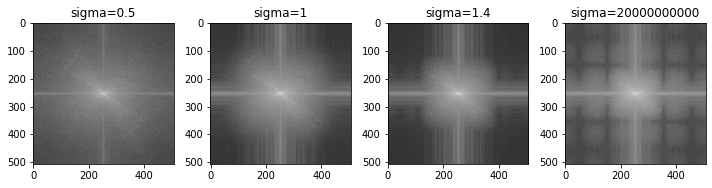

In [145]:
sigma = [0.5,1,1.4,20000000000]
count=1
plt.figure(figsize=(10,5))
for sig in sigma:
  gaussian = get_Gaussian_filter(sig,2)
  new_img= get_new_img(img,sig,2)
  plt.subplot(1,4,count)
  count+=1
  get_spectrogram(new_img,sig)
  plt.tight_layout()

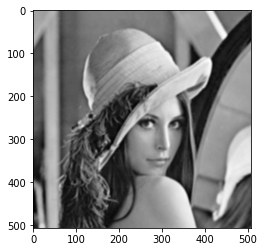

In [143]:
new_grey = get_new_img(img,5000000000000,2)
plt.imshow(new_grey)

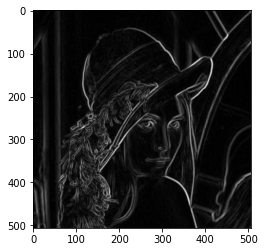

In [141]:
# step2.增强 通过求梯度幅值
W1, H1 = new_grey.shape
dx = np.zeros([W1-1, H1-1])
dy = np.zeros([W1-1, H1-1])
d = np.zeros([W1-1, H1-1])
threshold=1
for i in range(W1-1):
    for j in range(H1-1):   
        dx[i,j] = new_grey[i, j+1] - new_grey[i, j]
        dy[i,j] = new_grey[i+1, j] - new_grey[i, j]        
        d[i, j] = threshold*np.sqrt(np.square(dx[i,j]) + np.square(dy[i,j]))   # 图像梯度幅值作为图像强度值
         
plt.imshow(d, cmap="gray")

b- Write a function `nms(g_norm,g_theta)` which takes as input the gradient norm and direction and outputs a binary image with value 1 only for pixels that correspond to a maximum in the direction of the gradient.

c- Combine step 'a' and 'b' to extract edges with a gradient norm larger than a given threshold.

d- Add the hysteresis thresholding to step 'c' to implement a function computing the Canny edges.

Here is one way to do the hysteresis thresholding. Apply step 'c' with two thresholds $t_1 < t_2$. This yields a set of "strong pixels" (large threshold) and "weak pixels" (small threshold). Initialize a list of edge pixels by including only the set of strong pixels. For each pixel in this list, check if its neighboors are weak pixels. If they are, add them to the list of pixels to visit.

e- Run your code on at least four images of your own choosing. Use different parameters and comment on their effects.